In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv("../data/processed/twitter-financial-news-sentiment/samples/sample1.csv")

df.head()

,text,label
0,Sanofi Sees Profit Rising in 2020,1
1,$USO $XLE $OIL - Oil slides amid output uncert...,0
2,Do Hedge Funds Love Enstar Group Ltd. (ESGR)?,2
3,From the new quarterly forecast: The estimate ...,1
4,3 Under-the-Radar Stocks With Low Price-Book R...,2


In [185]:
df.describe()

,label
count,5027.000000
mean,1.139845
std,0.797765
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [186]:
https_count = df['text'].str.contains('https').sum()
print(f"number of tweets with sources: {https_count}")

print(f"percentage: {https_count / len(df)}")



number of twits with sources: 2228
percentage: 0.4432066839069027


In [187]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')


def tokenize_text(text: str) -> list[str]:
    """
    Tokenize the text into individual words using nltk or torchtext.
    """
    tokens = word_tokenize(text)
    
    return tokens

def remove_stop_words(tokenized_text: list[str]) -> list[str]:
    """
    Remove common stop words from tokenized text using nltk.
    """
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokenized_text if word.lower() not in stop_words]
    return filtered_tokens

def stem_words(tokenized_text: list[str]) -> list[str]:
    """
    Apply stemming to the tokenized text using nltk's PorterStemmer.
    """
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in tokenized_text]
    return stemmed_words

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxmartyshov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxmartyshov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [188]:
import re

def process_source_links(row):
    if 'https' in row['text']:
        row['text'] = re.sub(r'http\S+', '', row['text']).strip()
        row['has_source'] = 1
    else:
        row['has_source'] = 0
    return row

In [189]:
def preprocessing_stage_word_cloud(text):
    tokenized = tokenize_text(text)
    filtered = remove_stop_words(tokenized)
    stemmed = stem_words(filtered)
    joined = " ".join(stemmed)
    return joined

def clean_df_for_word_cloud(df):
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    
    # Apply processing to the copied dataframe
    df_copy = df_copy.apply(process_source_links, axis=1)
    df_copy['text'] = df_copy['text'].apply(preprocessing_stage_word_cloud)
    
    return df_copy

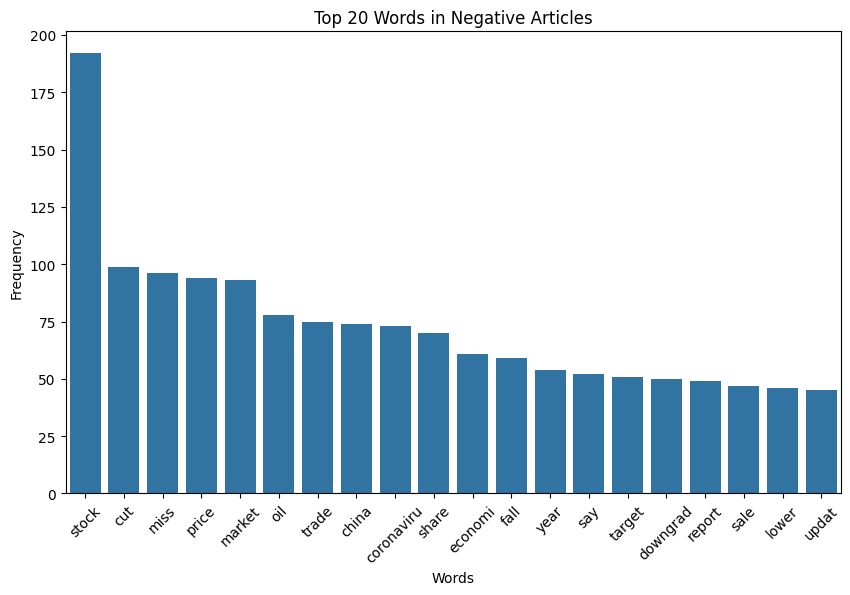

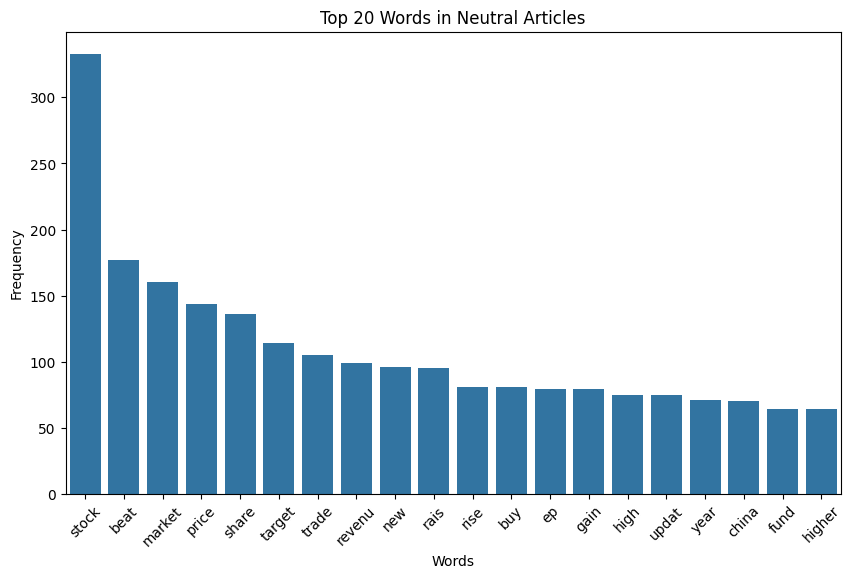

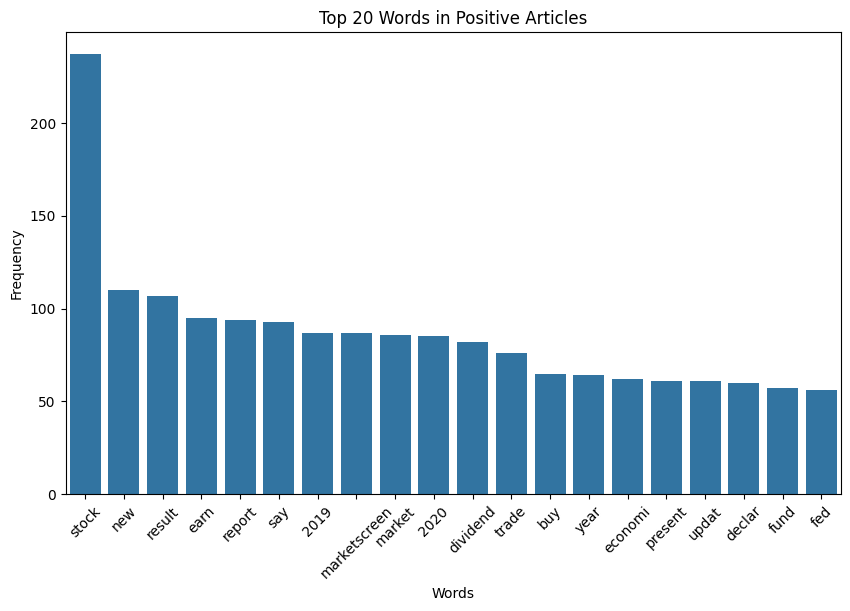

In [190]:
df_wc = clean_df_for_word_cloud(df)

from sklearn.feature_extraction.text import CountVectorizer

sentiments = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
    }

# Function to create and plot word frequency bar plots
def plot_word_frequencies(sentiment_label, n=10):
    text_data = df_wc[df_wc['label'] == sentiment_label]['text']

    # Use CountVectorizer to count word frequencies
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(text_data)
    word_sum = word_counts.sum(axis=0)
    
    # Create a DataFrame with words and their frequencies
    word_freq = pd.DataFrame(word_sum, columns=vectorizer.get_feature_names_out(), index=['count']).T
    word_freq = word_freq.sort_values(by='count', ascending=False).head(n)
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=word_freq.index, y=word_freq['count'])
    plt.title(f'Top {n} Words in {sentiments[str(sentiment_label)]} Articles')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Plot word frequencies for each sentiment
for label in range(3):
    plot_word_frequencies(label, n=20)

In [191]:
def lower_text(text: str):
    return text.lower()

def remove_numbers(text: str):
    """
    Substitute all punctuations with space in case of
    "there is5dogs".
    
    If subs with '' -> "there isdogs"
    With ' ' -> there is dogs
    """
    text_nonum = re.sub(r'\d+', ' ', text)
    return text_nonum

def remove_punctuation(text: str):
    """
    Substitute all punctuations with space in case of
    "hello!nice to meet you"
    
    If subs with '' -> "hellonice to meet you"
    With ' ' -> "hello nice to meet you"
    """
    text_nopunct = re.sub(r'[^\w\s]', ' ', text)
    return text_nopunct

def remove_multiple_spaces(text: str):
    """
    Replace multiple spaces with a single space.
    """
    text_no_doublespace = re.sub(r'\s+', ' ', text).strip()
    return text_no_doublespace

In [198]:
def preprocessing_text(text):
    _lowered = lower_text(text)
    _without_punct = remove_punctuation(_lowered)
    _single_spaced = remove_multiple_spaces(_without_punct)
    _tokenized = tokenize_text(_single_spaced)
    _without_sw = remove_stop_words(_tokenized)
    _stemmed = stem_words(_without_sw)
    
    return _stemmed

In [199]:
def preprocess(df):
    df_copy = df.copy()
    df_copy = df_copy.apply(process_source_links, axis=1)
    df_copy['text'] = df_copy['text'].apply(preprocessing_text)
    
    return df_copy

In [200]:
print(preprocess(df))

                                                   text  label  has_source
0     [copa, hold, stock, price, target, rais, 130, ...      1           0
1                  [news, corpor, nw, hedg, fund, snap]      1           0
2     [alxn, alexion, pharma, issu, statement, regar...      2           1
3     [feder, reserv, monday, roll, extraordinari, a...      2           1
4     [stock, market, updat, stock, market, lift, me...      1           0
...                                                 ...    ...         ...
5022  [cpst, eagl, ford, produc, order, anoth, capst...      1           1
5023             [bull, market, almost, one, saw, come]      1           0
5024  [novo, nordisk, disclosur, transact, data, nov...      2           1
5025            [maximu, ep, miss, 0, 01, miss, revenu]      0           0
5026  [mnuchin, get, done, year, top, list, next, ye...      2           0

[5027 rows x 3 columns]


In [ ]:
from sklearn.model_selection import train_test_split

ratio = 0.2
train, test = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)

In [14]:
from transformers import pipeline
sentiments = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
    }
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", framework="pt", device= 'mps')
for i in range(100):
    # print(f"text: {df.loc[0]['text']}")
    print(f"sentiment score: {classifier(df.loc[i]['text'])}")
    print(f"actual label: {sentiments[df.loc[i]['label']]}")
    print("--"*10)

sentiment score: [{'label': 'NEGATIVE', 'score': 0.9805347323417664}]
actual label: Neutral
--------------------
sentiment score: [{'label': 'NEGATIVE', 'score': 0.9834061861038208}]
actual label: Neutral
--------------------
sentiment score: [{'label': 'NEGATIVE', 'score': 0.9934166669845581}]
actual label: Positive
--------------------
sentiment score: [{'label': 'POSITIVE', 'score': 0.9620177149772644}]
actual label: Positive
--------------------
sentiment score: [{'label': 'NEGATIVE', 'score': 0.5487691164016724}]
actual label: Neutral
--------------------
sentiment score: [{'label': 'NEGATIVE', 'score': 0.9996022582054138}]
actual label: Positive
--------------------
sentiment score: [{'label': 'NEGATIVE', 'score': 0.9947675466537476}]
actual label: Neutral
--------------------
sentiment score: [{'label': 'NEGATIVE', 'score': 0.974193274974823}]
actual label: Neutral
--------------------
sentiment score: [{'label': 'NEGATIVE', 'score': 0.9940714240074158}]
actual label: Negative
-

In [21]:
df = pd.read_csv("../data/processed/twitter-financial-news-sentiment/samples/sample3.csv")
df["text"].apply(len).min()

np.int64(4)

In [22]:
df.loc[df['text'].apply(len).idxmin()]

text     ACHV
label       2
Name: 3105, dtype: object

## Now we will do actual preprocessing for hugging face

In [2]:
import pandas as pd

df = pd.read_csv("../data/processed/twitter-financial-news-sentiment/samples/sample1.csv")

df.head()

,text,label
0,Copa Holdings stock price target raised to $13...,1
1,News Corporation (NWS): Hedge Funds Are Snappi...,1
2,$ALXN: Alexion Pharma issues statement in rega...,2
3,The Federal Reserve on Monday rolled out an ex...,2
4,Stock Market Update: Stock market lifted by me...,1


In [3]:

def process_source_links(row):
    if 'https' in row['text']:
        row['text'] = re.sub(r'http\S+', '', row['text']).strip()
        row['has_source'] = 1
    else:
        row['has_source'] = 0
    return row

In [4]:
df = df.apply(process_source_links, axis=1)

In [5]:
df.head()

,text,label,has_source
0,Copa Holdings stock price target raised to $13...,1,0
1,News Corporation (NWS): Hedge Funds Are Snappi...,1,0
2,$ALXN: Alexion Pharma issues statement in rega...,2,1
3,The Federal Reserve on Monday rolled out an ex...,2,1
4,Stock Market Update: Stock market lifted by me...,1,0


In [6]:
def count_words(text):
    return len(str(text).split())

df['text'].apply(count_words).max()

np.int64(31)

In [10]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset


class FinancialTweetsDataset(Dataset):
    def __init__(self, texts, has_source, labels, tokenizer, max_length=32):
        self.texts = texts
        self.has_source = has_source
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        has_source = self.has_source[idx]

        encoding = self.tokenizer(text, padding="max_length", max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'has_source': torch.tensor(has_source, dtype=torch.float),
            'labels': torch.tensor(label, dtype= torch.long)
        }

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
dataset = FinancialTweetsDataset(df['text'].tolist(), df['has_source'].tolist(), df['label'].tolist(), tokenizer)
len(dataset)

/Users/maxmartyshov/Desktop/IU/year3/PMDL/Sentiment_Analysis_for_Financial_News/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


5027